In [1]:
import openai

print(openai.__version__)

1.34.0


## Assistants API 개요

새로운 [Assistants API](https://platform.openai.com/docs/assistants/overview)는 [Chat Completions API](https://platform.openai.com/docs/guides/text-generation/chat-completions-api)를 발전시킨 것으로, 개발자가 어시스턴트와 유사한 경험을 쉽게 만들고 코드 해석기 및 검색과 같은 강력한 도구에 액세스할 수 있도록 합니다.

### Chat Completions API

**Chat Completions API**의 기본 요소는 `Messages`이며, 여기서 `Model`(`gpt-3.5-turbo`, `gpt-4o-mini` 등)을 사용하여 `Completion`을 수행합니다. 이 API는 다음과 같은 모드를 지원합니다:

- **기본 챗봇 모드**
- **JSON 모드**
- **이미지 모드**
- **함수 모드**

### Assistant API

함수 모드를 확장한 것이 바로 `Assistant API`입니다. 이전 함수 모드에서는 다음과 같은 기능들을 수행할 수 없었음.

- 외부 엑셀이나 CSV 파일을 읽어서 통계나 머신러닝 분석을 수행
- Python 코드를 직접 작성하고 실행
- 외부 문서를 읽고 질의응답 수행

그러나, Assistant API는 이러한 기능들을 모두 지원합니다. 다음과 같은 다양한 기능을 수행할 수 있습니다:

- **검색 (search)**
- **문서 검색 (retrieval)**
- **코드 실행 (code interpreter)**

이는`Langchain Agent와 유사한 기능을 제공`합니다.

## Assistants API의 기본 요소

![Assistants API Diagram](https://teddylee777.github.io/images/2024-02-13-openai-assistant-tutorial/assistants_overview_diagram.png)

- **Assistants**: 모델(GPT-3.5, GPT-4 등), instruction(지시문/프롬프트), tools(도구), files(업로드한 파일)을 캡슐화하는 역할을 합니다.
- **Threads**: 하나의 대화 채널로, 메시지(Message)를 담을 수 있으며, ChatGPT 기준 하나의 대화 스레드의 개념으로 생각하면 됩니다.
- **Runs**: `Assistant` + `Thread` 에서의 실행을 구동합니다. `Run` 단계에서 `tools(도구)`의 활용 여부가 결정되기도 합니다. 또한, `Run`을 수행한 후 Assistant가 응답한 결과를 처리할 때도 사용할 수 있습니다.

위의 요소들이 유기적으로 동작하면서 결국 상태가 있는(stateful) 사용자 경험을 제공합니다.

### 튜토리얼

아래에서는 각각의 요소들의 역할과 동작 원리에 대해 차례대로 알아보겠습니다.

1. **assistant 만들기**: `beta.assistants.create`
2. **thread 만들기**: `beta.thread.create`
3. **thread에 message 추가하기**: `beta.threads.messages.create`
4. **message가 추가된 thread를 run 시키기**: `beta.threads.runs.create`
5. **thread의 상태 알아보기**: `beta.threads.runs.retrieve`
6. **thread에 달려있는 메시지 알아보기**: `beta.threads.messages.list`

이 튜토리얼을 통해 Assistants API의 각 구성 요소와 그 동작 원리에 대해 더 깊이 이해할 수 있습니다.

### Helper 함수


`show_json` 함수는 인자로 받은 객체의 모델을 JSON 형태로 변환하여 출력합니다.

Assistant 가 응답한 결과를 분석할 때 print 목적으로 활용하는 함수입니다.


In [1]:
import json


def show_json(obj):
    # obj의 모델을 JSON 형태로 변환한 후 출력합니다.
    display(json.loads(obj.model_dump_json()))

In [2]:
# API KEY 정보를 불러옵니다
from dotenv import load_dotenv

load_dotenv()

True

## Assistants API


## 1. Assistant를 생성하기
### `beta.assistants.create`

### Input Parameters
- `model`: 사용할 모델, 예를 들어 `gpt-4-turbo`, `gpt-3.5-turbo` 등이 있습니다.
- `name`: Assistant의 이름, 최대 256자.
- `instructions`: 시스템 instruction, 최대 256k.
- `tools`: 사용 가능한 도구들의 리스트. 최대 128개 도구까지 가능하며, `code_interpreter`, `file_search`, 또는 함수 등을 포함할 수 있습니다. 항상 딕셔너리 스타일로 `type`과 도구 이름을 명기합니다.

### Example Code

```python
from openai import OpenAI
client = OpenAI()

my_assistant = client.beta.assistants.create(
    instructions="You are a personal math tutor. When asked a question, write and run Python code to answer the question.",
    name="Math Tutor",
    tools=[{"type": "code_interpreter"}],
    model="gpt-4-turbo",
)
print(my_assistant)
```

### Output Format
- 반드시 `assistant-id`를 추적해야 합니다.

```json
{
  "id": "asst_abc123",
  "object": "assistant",
  "created_at": 1698984975,
  "name": "Math Tutor",
  "description": null,
  "model": "gpt-4o-mini",
  "instructions": "You are a personal math tutor. When asked a question, write and run Python code to answer the question.",
  "tools": [
    {
      "type": "code_interpreter"
    }
  ],
  "metadata": {},
  "top_p": 1.0,
  "temperature": 1.0,
  "response_format": "auto"
}
```

이 예제는 `Math Tutor`라는 이름의 Assistant를 생성하며, 이 Assistant는 수학 튜터 역할을 수행하고 Python 코드를 작성하고 실행할 수 있는 `code_interpreter` 도구를 사용합니다. 생성된 Assistant의 ID를 추적하여 후속 작업에 활용할 수 있습니다.

In [3]:
from openai import OpenAI

# OpenAI API를 사용하기 위한 클라이언트 객체를 생성합니다.
client = OpenAI()

# 수학 과외 선생님 역할을 하는 챗봇을 생성합니다.
# 이 챗봇은 간단한 문장이나 한 문장으로 질문에 답변합니다.
assistant = client.beta.assistants.create(
    name="Math Tutor",
    instructions="You are a personal math tutor. Answer questions briefly, in a sentence or less.",
    model="gpt-4o-mini",
)
# 생성된 챗봇의 정보를 JSON 형태로 출력합니다.
show_json(assistant)

{'id': 'asst_OrjUNkXDcvGlpfugB5CRHHjs',
 'created_at': 1722440457,
 'description': None,
 'instructions': 'You are a personal math tutor. Answer questions briefly, in a sentence or less.',
 'metadata': {},
 'model': 'gpt-4o-mini',
 'name': 'Math Tutor',
 'object': 'assistant',
 'tools': [],
 'response_format': 'auto',
 'temperature': 1.0,
 'tool_resources': {'code_interpreter': None, 'file_search': None},
 'top_p': 1.0}

생성한 `ASSISTANT ID` 를 기억해함.

`ASSISTANT_ID` 를 계속 추적하여 튜토리얼을 진행할 예정임. => 따라서, 별도의 변수에 담아 저장하도록 하겠습니다.

In [4]:
print(assistant)

Assistant(id='asst_OrjUNkXDcvGlpfugB5CRHHjs', created_at=1722440457, description=None, instructions='You are a personal math tutor. Answer questions briefly, in a sentence or less.', metadata={}, model='gpt-4o-mini', name='Math Tutor', object='assistant', tools=[], response_format='auto', temperature=1.0, tool_resources=ToolResources(code_interpreter=None, file_search=None), top_p=1.0)


In [5]:
# 별도의 변수에 저장 
ASSISTANT_ID = assistant.id
print(f"[생성한 Assistants ID]\n{ASSISTANT_ID}")

[생성한 Assistants ID]
asst_OrjUNkXDcvGlpfugB5CRHHjs


## 2. Threads(스레드) 를 생성하기 
### `beta.threads.create`

새로운 Thread를 생성하고 thread-id를 추적합니다. Threads는 하나의 대화 채널로, 메시지를 담을 수 있음!!
쉽게 말해 채팅방이라 생각하면 됨


- 새로운 대화 스레드를 생성해보기


In [6]:
# 새로운 스레드를 생성합니다.
thread = client.beta.threads.create()

# 생성된 스레드의 정보를 JSON 형식으로 출력합니다.
show_json(thread)

{'id': 'thread_34Wa2ymzMozHFxiXkoW7Sa77',
 'created_at': 1722440578,
 'metadata': {},
 'object': 'thread',
 'tool_resources': {'code_interpreter': None, 'file_search': None}}

## 3. 생성된 Threads(스레드)에 메시지를 추가하기
### `beta.threads.messages.create`

### 설명
- **Threads**: 메시지 풀을 관리하는 집합체로, 메시지의 상태 관리도 포함됩니다.
- **Message**: 단일 메시지이며, 각 메시지는 역할(role)과 컨텐츠(content)로 구성되어 있습니다.
- `한 개의 Thread는 여러 개의 메시지를 가질 수 있으며, 메시지 히스토리 관리를 직접 할 필요가 없습니다`. 즉, 한 개의 `Thread`는 여러 개의 순차적으로 연결된 `Message`들을 포함합니다.

### Input Parameters
- `thread-id`: 생성된 Thread의 ID
- `role`: 메시지의 역할 (예: "user", "assistant", "system")
- `content`: 메시지의 내용

- 이전 단계에서 생성한 Thread의 ID를 사용하여 새로운 메시지를 추가합니다. 생성된 메시지의 ID를 추적하여 후속 작업에 활용할 수 있습니다.

In [8]:
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="다음의 방정식을 풀고 싶습니다. `3x**2 + 11x - 10 = 0`. 수학선생님 도와주실 수 있나요?",
)
show_json(message)

{'id': 'msg_yTllgMja08wwuxSzxWif7ZxD',
 'assistant_id': None,
 'attachments': [],
 'completed_at': None,
 'content': [{'text': {'annotations': [],
    'value': '다음의 방정식을 풀고 싶습니다. `3x**2 + 11x - 10 = 0`. 수학선생님 도와주실 수 있나요?'},
   'type': 'text'}],
 'created_at': 1722440763,
 'incomplete_at': None,
 'incomplete_details': None,
 'metadata': {},
 'object': 'thread.message',
 'role': 'user',
 'run_id': None,
 'status': None,
 'thread_id': 'thread_34Wa2ymzMozHFxiXkoW7Sa77'}

> **참고**
> ‼️ 전체 대화 기록을 매번 보내지 않더라도, 각 실행마다 전체 대화 기록의 토큰에 대해 여전히 요금이 부과됨. 과금 주의

## 4. assistant + thread + message 묶음을 실행하기

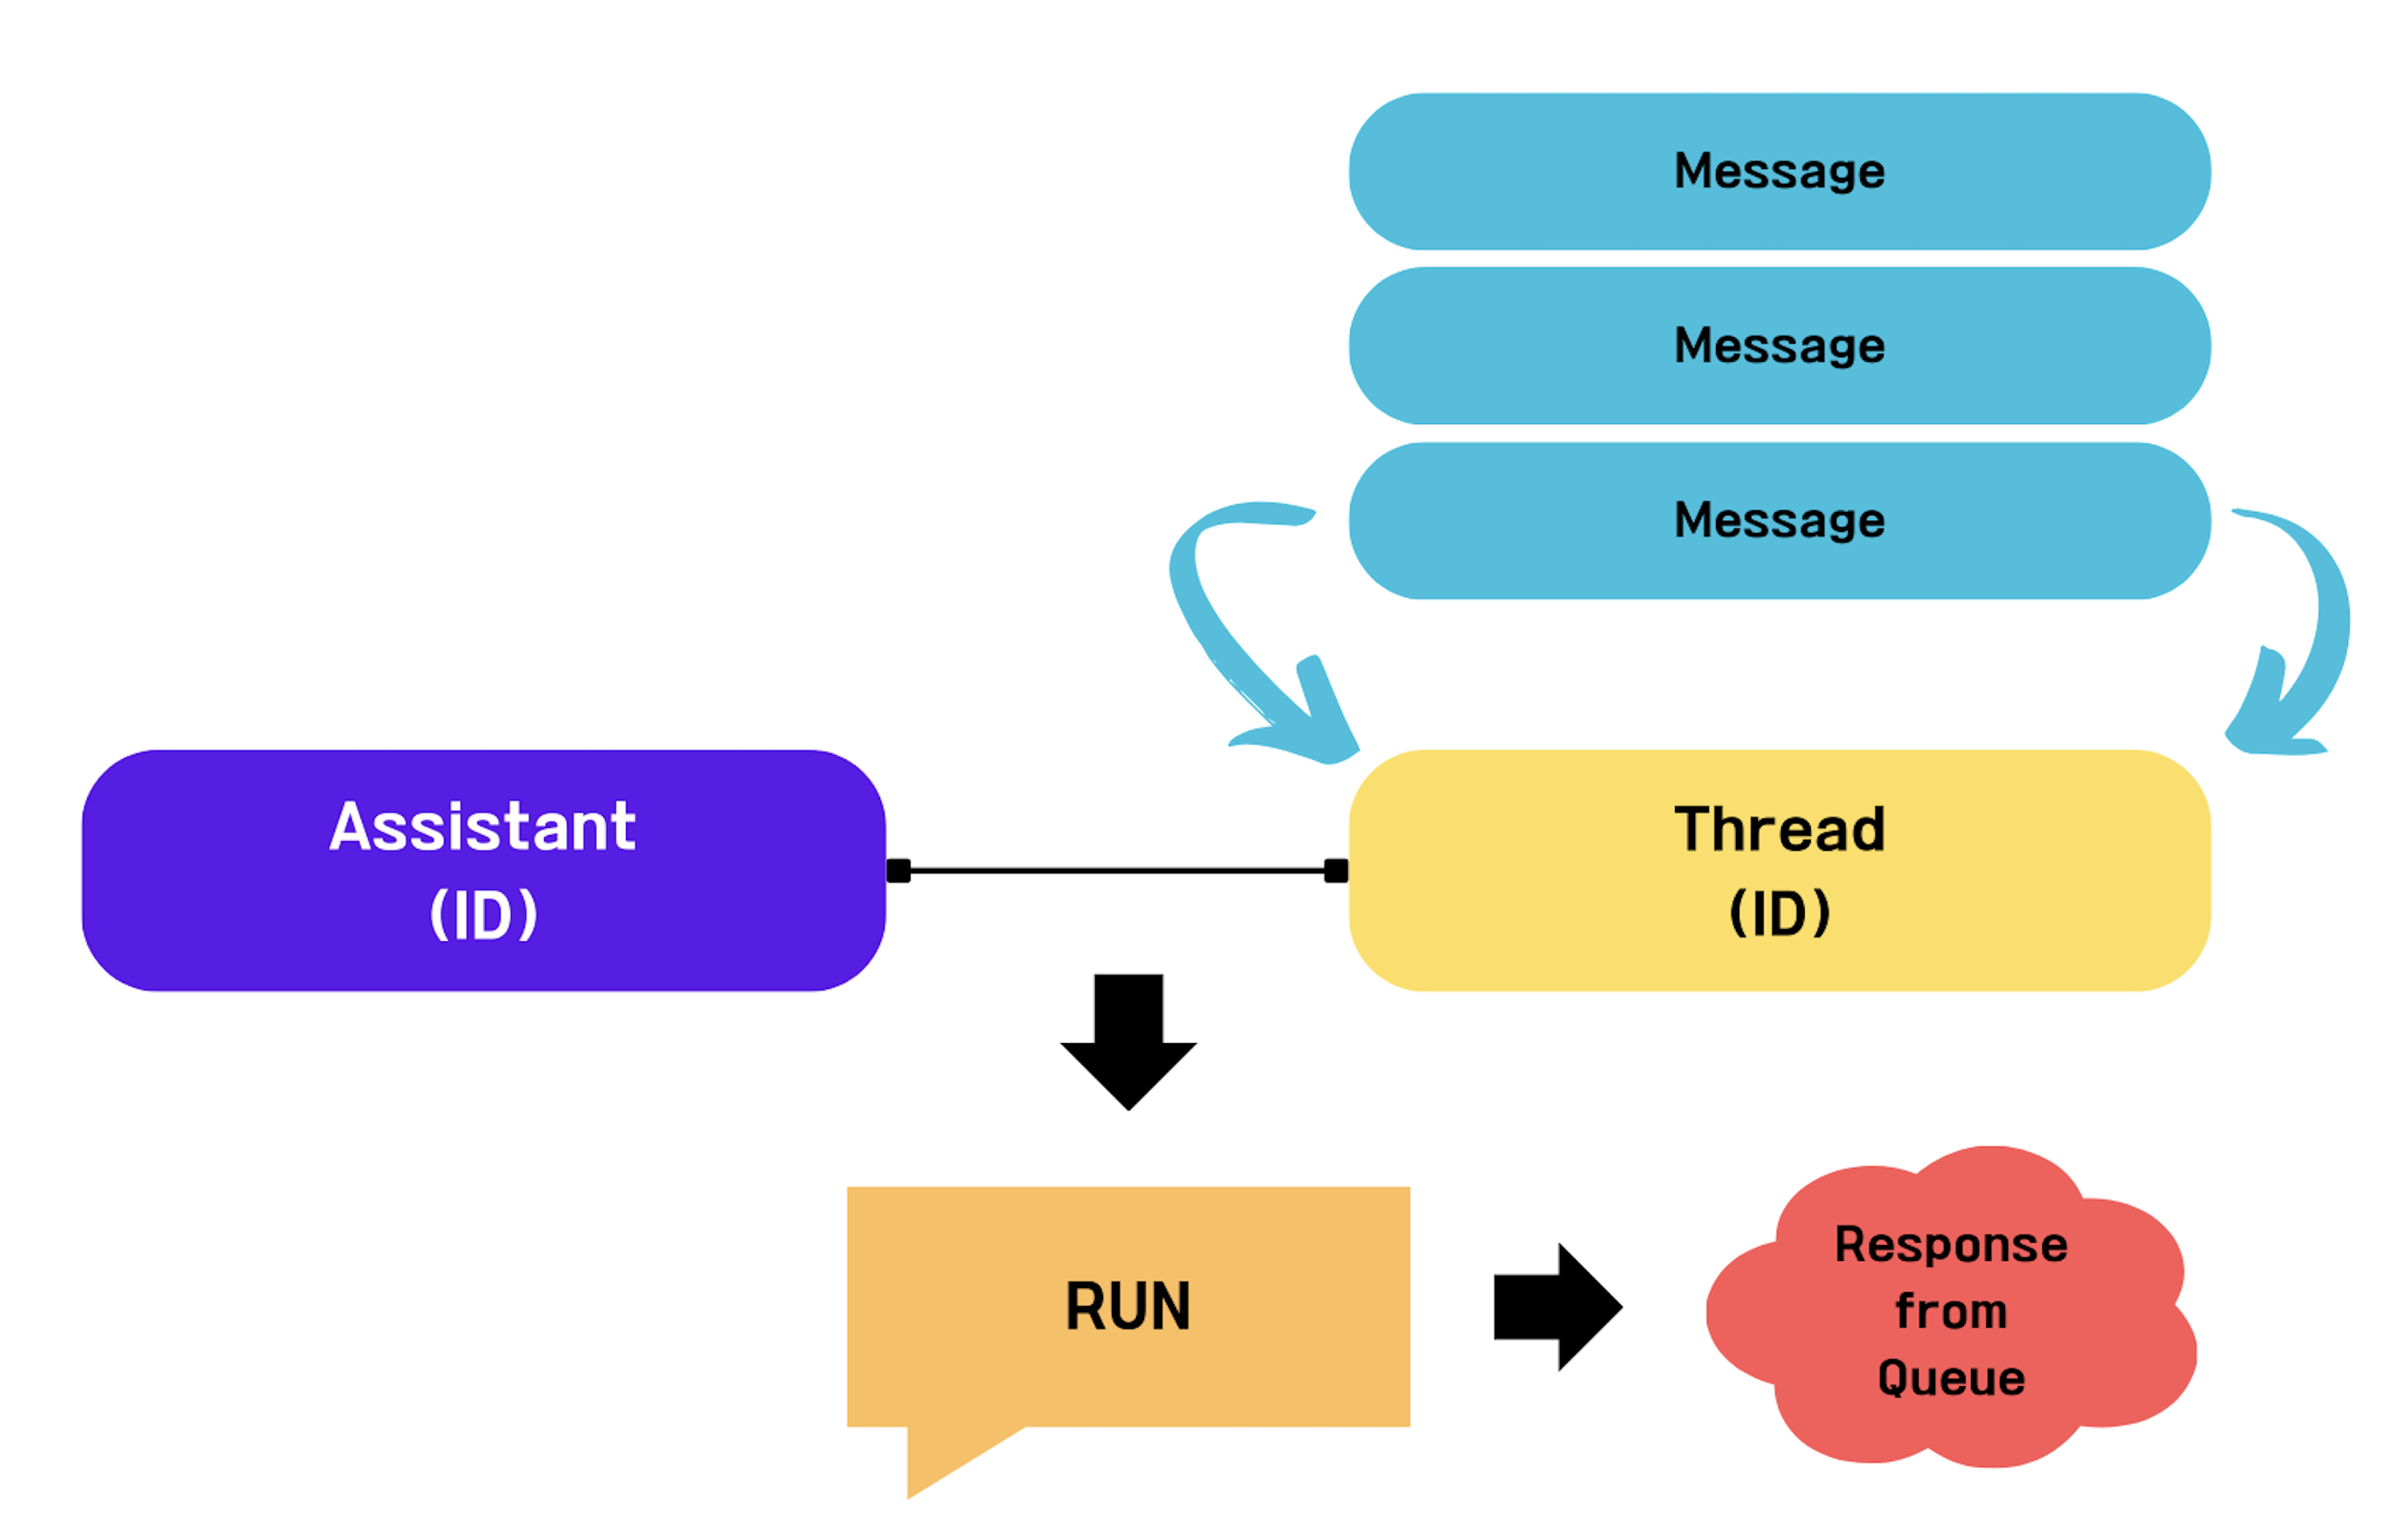

우리가 만든 **Thread**가 이전에 만든 Assistant와 연결되어 있지 **않았음!!!!!!!!!!!!!!!!!** 

`Thread` 는 `Assistant`와 **독립적으로 존재!!!!!!!** 

`Run` 이 수행되기 위해서는 2가지 전제 조건이 존재한다.

>누가(`Assistant`), 어떤 대화(`Thread`) 를 실행할 것인가! 이다.

즉, `Run` 이 수행되기 위한 조건에는 `Assistant` ID 와 `Thread` ID 가 지정되어야 한다.


### 요약

Run을 생성하면 `Assistant` 에게 `Thread` 에 들어있는 `Message` 목록을 살펴보고 조치를 취하라는 지시를 합니다. 여기서 조치는 단일 텍스트 응답(일반 채팅) 일 수도 있고, tools(도구) 사용일 수도 있습니다.

> Run은 Assistants API와 Chat Completions API 사이의 주요 차이점입니다. Chat `Completions에서는 모델이 단일 메시지로만 응답`하지만, `Assistants API에서는 Run이 하나 또는 여러 도구를 사용하고, Thread에 여러 메시지를 추가할` 수 있습니다.



사용자에게 응답하도록 Assistant를 활성화하려면 Run을 생성합시다.

앞서 언급했듯이, `Assistant` 와 `Thread` **둘 다 지정** 해야 합니다.

### input parameter
- assistant-id
- tread-id

### output parameter
- run-id = 이것도 계속 추적합니다. 현재 run 상태를 알아봐야 하니까.
- status = 이것도 현재 상태를 체크한다.

In [9]:
# 실행할 Run 을 생성합니다.
# Thread ID 와 Assistant ID 를 지정합니다.
run = client.beta.threads.runs.create(
    thread_id=thread.id,  # 생성한 스레드 ID
    assistant_id=assistant.id,  # 적용할 Assistant ID
)
show_json(run)

{'id': 'run_xeAUB3b0XY271dT5PGib63zd',
 'assistant_id': 'asst_OrjUNkXDcvGlpfugB5CRHHjs',
 'cancelled_at': None,
 'completed_at': None,
 'created_at': 1722441131,
 'expires_at': 1722441731,
 'failed_at': None,
 'incomplete_details': None,
 'instructions': 'You are a personal math tutor. Answer questions briefly, in a sentence or less.',
 'last_error': None,
 'max_completion_tokens': None,
 'max_prompt_tokens': None,
 'metadata': {},
 'model': 'gpt-4o-mini',
 'object': 'thread.run',
 'parallel_tool_calls': True,
 'required_action': None,
 'response_format': 'auto',
 'started_at': None,
 'status': 'queued',
 'thread_id': 'thread_34Wa2ymzMozHFxiXkoW7Sa77',
 'tool_choice': 'auto',
 'tools': [],
 'truncation_strategy': {'type': 'auto', 'last_messages': None},
 'usage': None,
 'temperature': 1.0,
 'top_p': 1.0,
 'tool_resources': {}}

## 5. thread 의 상태를 체크하기 

### `beta.threads.runs.retrieve`

Chat Completions API에서 완성을 생성하는 것과 달리, **Run을 생성하는 것은 비동기 작업입니다**.

이는 Run의 메타데이터와 함께 즉시 반환되며, `status` 는 `queued`(대기중) 으로 표기됩니다.

`status`는 Assistant가 작업을 수행함에 따라(도구 사용 및 메시지 추가와 같은) 업데이트될 것입니다. 상태 값은 아래의 목록을 참고하세요.

`status` 목록

- `queued`: 아직 실행이 되지 않고 대기중인 상태
- `in_progress`: 처리중
- `requires_action`: 사용자 입력 대기중
- `cancelling`: 작업 취소중
- `cancelled`: 작업 취소 완료
- `failed`: 실패(오류)
- `completed`: 작업 완료
- `expired`: 작업 만료

### input parameter
- run-id
- thread-id

### output parameter
- status


Assistant가 처리를 완료했는지 알기 위해서는 Run을 반복해서 폴링할 수 있습니다. (OpenAI 는 곧 실시간 스트리밍 지원이 곧 제공될 예정이라고 한다!)


아래는 Run 의 `status`(상태) 를 폴링하면서 주기적으로 확인하는 코드이다..

이렇게 주기적으로 확인하면서 `status` 가 `completed` 될 때까지 기다린다.


In [11]:
import time


def wait_on_run(run, thread):
    # 주어진 실행(run)이 완료될 때까지 대기합니다.
    # status 가 "queued" 또는 "in_progress" 인 경우에는 계속 polling 하며 대기합니다.
    while run.status == "queued" or run.status == "in_progress":
        # run.status 를 업데이트합니다.
        run = client.beta.threads.runs.retrieve(
            thread_id=thread.id,
            run_id=run.id,
        )
        # API 요청 사이에 잠깐의 대기 시간을 두어 서버 부하를 줄입니다.
        time.sleep(0.5)
    return run

In [12]:
# run 객체를 대기 상태로 설정하고, 해당 스레드에서 실행을 완료할 때까지 기다립니다.
run = wait_on_run(run, thread)

# status 가 "complete" 인 경우에는 결과를 출력합니다.
show_json(run)

{'id': 'run_xeAUB3b0XY271dT5PGib63zd',
 'assistant_id': 'asst_OrjUNkXDcvGlpfugB5CRHHjs',
 'cancelled_at': None,
 'completed_at': 1722441135,
 'created_at': 1722441131,
 'expires_at': None,
 'failed_at': None,
 'incomplete_details': None,
 'instructions': 'You are a personal math tutor. Answer questions briefly, in a sentence or less.',
 'last_error': None,
 'max_completion_tokens': None,
 'max_prompt_tokens': None,
 'metadata': {},
 'model': 'gpt-4o-mini',
 'object': 'thread.run',
 'parallel_tool_calls': True,
 'required_action': None,
 'response_format': 'auto',
 'started_at': 1722441131,
 'status': 'completed',
 'thread_id': 'thread_34Wa2ymzMozHFxiXkoW7Sa77',
 'tool_choice': 'auto',
 'tools': [],
 'truncation_strategy': {'type': 'auto', 'last_messages': None},
 'usage': {'completion_tokens': 151, 'prompt_tokens': 85, 'total_tokens': 236},
 'temperature': 1.0,
 'top_p': 1.0,
 'tool_resources': {}}

## 6. run이 completed된 후, thread에 달려있는 메시지를 열어보기 

### `beta.threads.messages.list`

### Message(메시지)

### input parameter
- thread_id
- limit = 1-100. default 20
- order = asc, desc (default)
- after = message-id 특정 run 이후 모든 메시지
- before = message-id 특정 run 이전 모든 메시지

Run이 완료되었으므로, Assistant에 의해 처리된 결과를 보기 위해 Thread에서 Messages를 확인할 수 있습니다.


In [13]:
# thread.id를 사용하여 메시지 목록을 가져옵니다.
messages = client.beta.threads.messages.list(thread_id=thread.id)

# 결과를 출력합니다.
show_json(messages)

{'data': [{'id': 'msg_CykmdYCnkqH4iZAAXgrUXstb',
   'assistant_id': 'asst_OrjUNkXDcvGlpfugB5CRHHjs',
   'attachments': [],
   'completed_at': None,
   'content': [{'text': {'annotations': [],
      'value': '물론입니다! 방정식 `3x^2 + 11x - 10 = 0`의 해는 다음과 같습니다: \n\n\\( x = \\frac{-11 \\pm \\sqrt{11^2 - 4 \\cdot 3 \\cdot (-10)}}{2 \\cdot 3} = \\frac{-11 \\pm \\sqrt{121 + 120}}{6} = \\frac{-11 \\pm \\sqrt{241}}{6} \\).\n\n따라서, 두 근은 \\( x = \\frac{-11 + \\sqrt{241}}{6} \\)와 \\( x = \\frac{-11 - \\sqrt{241}}{6} \\)입니다.'},
     'type': 'text'}],
   'created_at': 1722441132,
   'incomplete_at': None,
   'incomplete_details': None,
   'metadata': {},
   'object': 'thread.message',
   'role': 'assistant',
   'run_id': 'run_xeAUB3b0XY271dT5PGib63zd',
   'status': None,
   'thread_id': 'thread_34Wa2ymzMozHFxiXkoW7Sa77'},
  {'id': 'msg_yTllgMja08wwuxSzxWif7ZxD',
   'assistant_id': None,
   'attachments': [],
   'completed_at': None,
   'content': [{'text': {'annotations': [],
      'value': '다음의 방정식을 풀고

In [14]:
print(messages.data[0].content[0].text.value)

물론입니다! 방정식 `3x^2 + 11x - 10 = 0`의 해는 다음과 같습니다: 

\( x = \frac{-11 \pm \sqrt{11^2 - 4 \cdot 3 \cdot (-10)}}{2 \cdot 3} = \frac{-11 \pm \sqrt{121 + 120}}{6} = \frac{-11 \pm \sqrt{241}}{6} \).

따라서, 두 근은 \( x = \frac{-11 + \sqrt{241}}{6} \)와 \( x = \frac{-11 - \sqrt{241}}{6} \)입니다.


$$ x = \frac{-11 + \sqrt{241}}{6} $$

$$ x = \frac{-11 - \sqrt{241}}{6} $$ 

보시다시피, 메시지는 역순으로 정렬됩니다.

이는 가장 최근의 결과가 항상 최상단에 있도록 하기 위해서입니다(결과는 `page` 별로 나누어 확인할 수 있습니다).

따라서, `Chat Completions API` 에서 메시지의 순서와 반대이기 때문에 혼란을 야기할 수도 있습니다.


이전에 받은 답변이 단답형 답변이라서, 조금 더 자세히 설명해 달라고 요청해 보겠습니다(이전의 대화내용을 기억하고 있는지 확인해 보기 위함입니다).


In [15]:
# 스레드에 추가할 메시지 생성
message = client.beta.threads.messages.create(
    thread_id=thread.id,
    role="user",
    content="설명이 잘 이해가 가지 않습니다. 좀 더 자세히 설명해 주실 수 있나요?",
)

# 실행을 시작함
run = client.beta.threads.runs.create(
    thread_id=thread.id,
    assistant_id=assistant.id,
)

# 완료될 때까지 대기
wait_on_run(run, thread)

# 마지막 사용자 메시지 이후에 추가된 모든 메시지를 검색
messages = client.beta.threads.messages.list(
    thread_id=thread.id, order="asc", after=message.id
)
show_json(messages)

{'data': [{'id': 'msg_h9it6cGYhO1359v5SFRfkvx5',
   'assistant_id': 'asst_OrjUNkXDcvGlpfugB5CRHHjs',
   'attachments': [],
   'completed_at': None,
   'content': [{'text': {'annotations': [],
      'value': '물론입니다! 방정식 \\(3x^2 + 11x - 10 = 0\\)를 풀이하는 과정은 다음과 같습니다:\n\n1. **주어진 방정식 확인**: \n   \\[ 3x^2 + 11x - 10 = 0 \\]\n\n2. **근의 공식을 사용하기**: \n   근의 공식은 \n   \\[ x = \\frac{-b \\pm \\sqrt{b^2 - 4ac}}{2a} \\]\n   여기서 \\(a = 3\\), \\(b = 11\\), \\(c = -10\\)입니다.\n\n3. **값 대입하기**:\n   \\[ b^2 - 4ac = 11^2 - 4 \\cdot 3 \\cdot (-10) \\]\n   \\[ = 121 + 120 = 241 \\]\n\n4. **루트 계산하기**:\n   \\[ \\sqrt{241} \\]은 근사값 약 15.52입니다.\n\n5. **근 구하는 과정**:\n   \\[ x = \\frac{-11 \\pm \\sqrt{241}}{6} \\]\n   즉, 두 개의 해는 \n   \\[ x_1 = \\frac{-11 + \\sqrt{241}}{6} \\]\n   \\[ x_2 = \\frac{-11 - \\sqrt{241}}{6} \\]\n\n6. **최종 결과**:\n   이 두 수치가 방정식의 해가 됩니다.\n\n이해가 더 잘 되셨나요? 추가 질문이 있으면 말씀해 주세요!'},
     'type': 'text'}],
   'created_at': 1722441409,
   'incomplete_at': None,
   'incomplete_details': None,
   'm

In [16]:
print(messages.data[0].content[0].text.value)

물론입니다! 방정식 \(3x^2 + 11x - 10 = 0\)를 풀이하는 과정은 다음과 같습니다:

1. **주어진 방정식 확인**: 
   \[ 3x^2 + 11x - 10 = 0 \]

2. **근의 공식을 사용하기**: 
   근의 공식은 
   \[ x = \frac{-b \pm \sqrt{b^2 - 4ac}}{2a} \]
   여기서 \(a = 3\), \(b = 11\), \(c = -10\)입니다.

3. **값 대입하기**:
   \[ b^2 - 4ac = 11^2 - 4 \cdot 3 \cdot (-10) \]
   \[ = 121 + 120 = 241 \]

4. **루트 계산하기**:
   \[ \sqrt{241} \]은 근사값 약 15.52입니다.

5. **근 구하는 과정**:
   \[ x = \frac{-11 \pm \sqrt{241}}{6} \]
   즉, 두 개의 해는 
   \[ x_1 = \frac{-11 + \sqrt{241}}{6} \]
   \[ x_2 = \frac{-11 - \sqrt{241}}{6} \]

6. **최종 결과**:
   이 두 수치가 방정식의 해가 됩니다.

이해가 더 잘 되셨나요? 추가 질문이 있으면 말씀해 주세요!


## 정리

1. Asssitant 생성. Assistant 의 역할 부여.
2. 새로운 Thread 생성. 해당 Thread 에 Message 추가.
3. Message 생성. Message 생성시 Thread 의 ID 를 입력하여 Message 추가
4. Run 생성. Run을 수행할 Assistant 와 실행할 Thread ID 를 지정 후 Run 실행
